Цель работы - освоить метод Transfer Learning для решения задачи классификации изображений. Для этого необходимо реализовать пайплайн обучения, используя предобученную сверточную нейронную сеть (ResNet-50), адаптировать ее под набор данных EuroSAT путем замены классификационного слоя и дообучения

In [ ]:
from google.colab import files
import os

uploaded = files.upload()

zip_filename = 'EuroSAT_RGB.zip'

!unzip -q {zip_filename} -d eurosat_data

data_dir = 'eurosat_data/EuroSAT_RGB'

Saving EuroSAT_RGB.zip to EuroSAT_RGB.zip


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Используется устройство: {device}")

Используется устройство: cuda


In [ ]:
#трансформация - ResNet требует нормализацию ImageNet
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], #средние значения пикселей для одного из цветовых каналов
                         [0.229, 0.224, 0.225]) #стандартные отклонения значений пикселей для одного из цветовых каналов
])

#загрузка датасета
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

#разделение на тренировочную, валидационную и тестовую выборки
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  #перемешиваем для обучения
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)     #не перемешиваем для валидации
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)   #и для теста

class_names = full_dataset.classes
print(f"Всего изображений: {total_len}")
print(f"Train: {train_len}, Val: {val_len}, Test: {test_len}")

Всего изображений: 27000
Train: 18900, Val: 5400, Test: 2700


*Описание набора данных*

EuroSAT версии RGB

Источник: Спутниковые снимки Sentinel-2

Содержание: 27000 изображений, разбитых на 10 классов

Размер изображений: 64x64 пикселя (в работе масштабировались до 224x224 для подачи в ResNet).

Разбиение данных:

* Тренировочная выборка (70%): 18900 изображений

* Валидационная выборка (20%): 5400 изображений

* Тестовая выборка (10%): 2700 изображений


*Выбор архитектуры*

В качестве базовой модели была выбрана ResNet-50

Глубокая архитектура с остаточными связями (вместо того чтобы каждый слой пытался выучить отображение, он теперь пытается выучить остаток), предотвращающая затухание градиента. Отличный баланс между точностью и производительностью

In [ ]:
#загрузка предобученной сети ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

#заморозка весов
for param in model.parameters():
    param.requires_grad = False

#замена классификатора
#model.fc - это последний полносвязный слой ResNet (1000 классов ImageNet)
#заменяем на новый слой с 10 выходами (10 классов EuroSAT)
#новый слой создается с requires_grad=True по умолчанию (разморожен)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

#модель на GPU
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support


criterion = nn.CrossEntropyLoss()
#оптимизируем только веса model.fc (остальные заморожены)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

def train_model(model, train_loader, test_loader, epochs):
    history = {
        'train_loss': [],
        'test_acc': [],
        'test_precision': [],
        'test_recall': [],
        'test_f1': []
    }

    for epoch in range(epochs):
        print(f'Эпоха {epoch+1}/{epochs}')

        #обучение
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)
        print(f'Потеря обучения {epoch_loss:.4f}')

        #валидация
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted', zero_division=0
        )

        test_acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100

        history['test_acc'].append(test_acc)
        history['test_precision'].append(precision)
        history['test_recall'].append(recall)
        history['test_f1'].append(f1)

        print(f'Test Acc: {test_acc:.2f}% | F1-Score: {f1:.4f}')

    return history

#запуск обучения
history = train_model(model, train_loader, test_loader, 7)

Эпоха 1/7
Потеря обучения 0.4980
Test Acc: 92.04% | F1-Score: 0.9196
Эпоха 2/7
Потеря обучения 0.2957
Test Acc: 94.41% | F1-Score: 0.9441
Эпоха 3/7
Потеря обучения 0.2639
Test Acc: 94.26% | F1-Score: 0.9426
Эпоха 4/7
Потеря обучения 0.2461
Test Acc: 94.07% | F1-Score: 0.9409
Эпоха 5/7
Потеря обучения 0.2199
Test Acc: 93.74% | F1-Score: 0.9380
Эпоха 6/7
Потеря обучения 0.2223
Test Acc: 94.74% | F1-Score: 0.9474
Эпоха 7/7
Потеря обучения 0.2126
Test Acc: 94.30% | F1-Score: 0.9432


НС на базе ResNet-50 продемонстрировала высокую эффективность и устойчивость в задаче классификации EuroSAT. Уже после первых двух эпох обучения была достигнута точность выше 94%. Итоговая точность на тестовой выборке составила 94.30% (при максимальном значении 94.74% на 6-й эпохе). Стабильное снижение потерь и отсутствие резкого падения метрик на тестовой выборке свидетельствуют об успешной адаптации предобученных признаков к новому домену

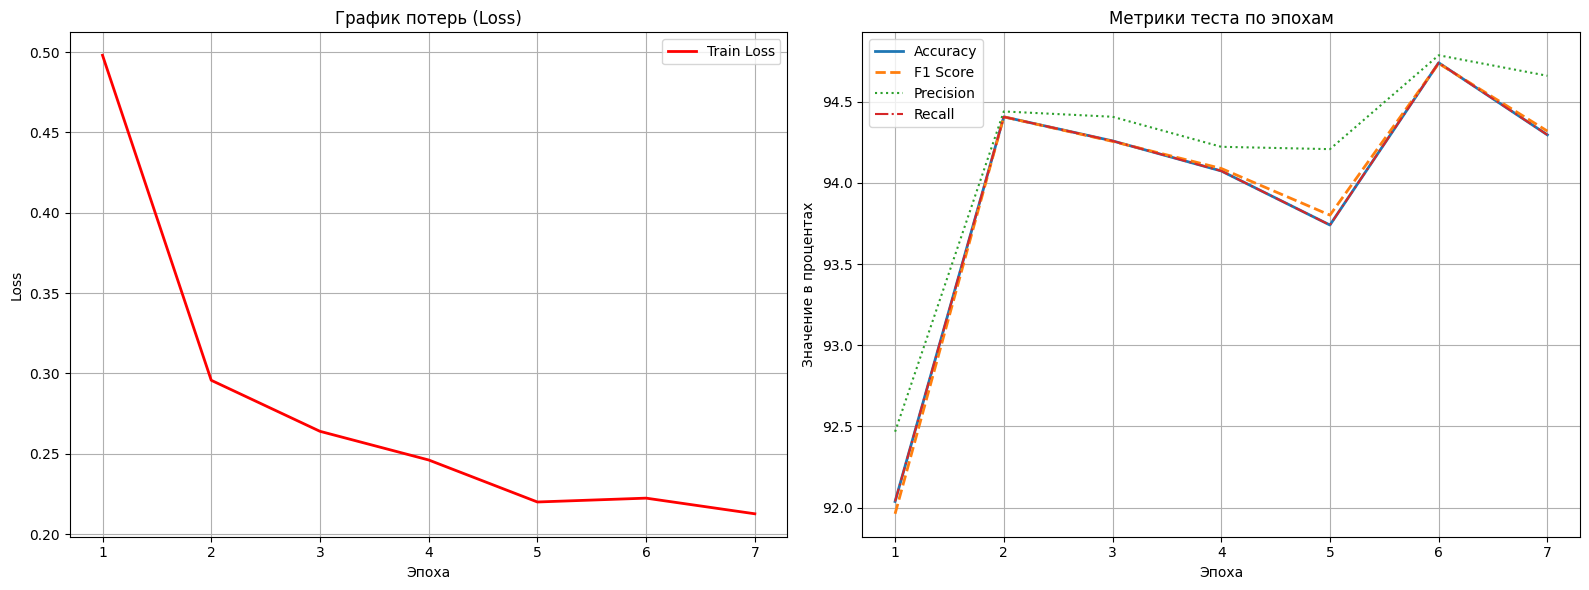

In [ ]:
def plot_training_history(history):
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 6))

    #потери
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], 'r-', label='Train Loss', linewidth=2)
    plt.title('График потерь (Loss)')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    #метрики
    plt.subplot(1, 2, 2)

    plt.plot(epochs_range, history['test_acc'], label='Accuracy', linewidth=2)

    plt.plot(epochs_range, [x * 100 for x in history['test_f1']],
             label='F1 Score', linestyle='--', linewidth=2)

    plt.plot(epochs_range, [x * 100 for x in history['test_precision']],
             label='Precision', linestyle=':', linewidth=1.5)

    plt.plot(epochs_range, [x * 100 for x in history['test_recall']],
             label='Recall', linestyle='-.', linewidth=1.5)

    plt.title('Метрики теста по эпохам')
    plt.xlabel('Эпоха')
    plt.ylabel('Значение в процентах')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

График потерь демонстрирует снижение ошибки обучения с 0.5 до 0.21, что говорит о том, что сеть успешно сходится

Accuracy и F1-Score вышли на плато в районе 94-95% уже к 2-3 эпохе, что подтверждает эффективность использования предобученных моделей

Финальный тест НС

In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='weighted', zero_division=0
)
accuracy = accuracy_score(test_labels, test_preds)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:  {recall:.4f}")
print(f"F1-Score:   {f1:.4f}")

Accuracy: 94.30%
Precision: 0.9466
Recall:  0.9430
F1-Score:   0.9432


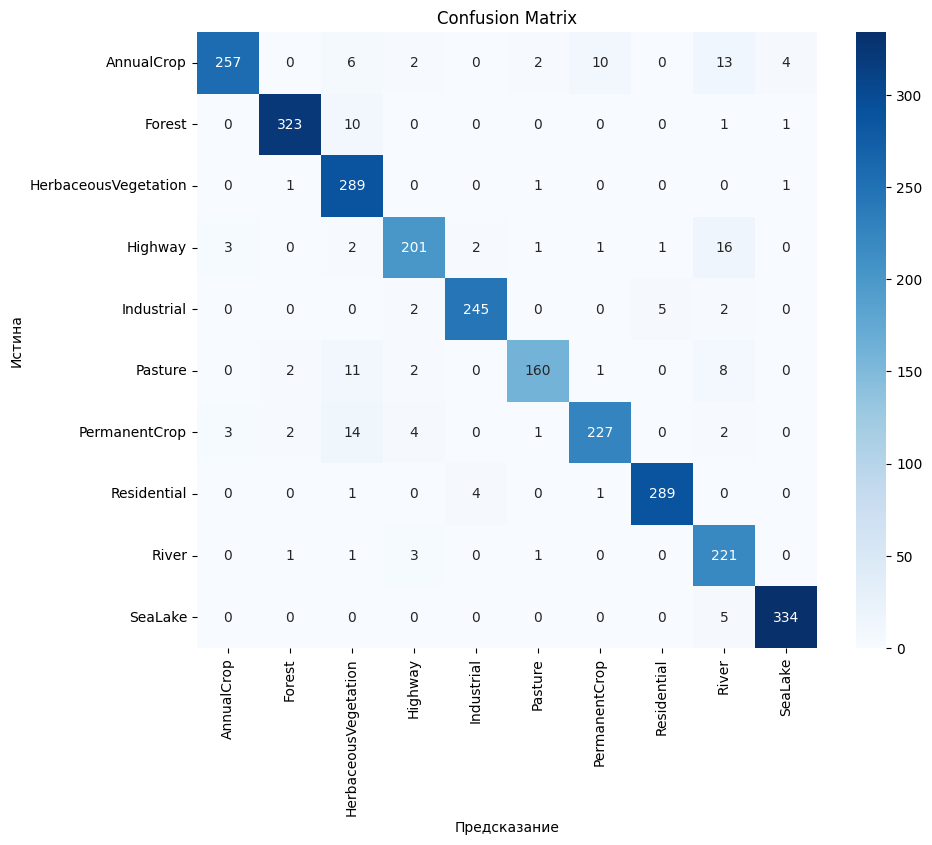

In [ ]:
#матрица ошибок для теста
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Истина')
plt.xlabel('Предсказание')
plt.show()

Диагональные элементы имеют наибольшие значения, что свидетельствует о правильной классификации подавляющего большинства примеров. Ошибки минимальны и вероятнее всего возникают из-за схожести линейной формы у классов, контраста с окружающей средой (например, река была перепутана с шоссе)

**Итоги**

Наилучшее качество классификации было зафиксировано на 6-й эпохе, где точность составила 94.74%, а F1-Score — 0.9474.

Несмотря на продолжение обучения до 7 эпохи, результаты (Accuracy 94.30%, F1-Score 0.9432) остались в пределах погрешности от максимального значения. Это свидетельствует об устойчивости обученного классификатора и отсутствии критического переобучения

Высокие значения F1-Score подтверждают, что модель обеспечивает хороший баланс между Precision и Recall. Модель не имеет слепых зон и одинаково хорошо распознает все 10 классов ландшафта, несмотря на визуальную схожесть некоторых из них


Проведенная работа успешно продемонстрировала, что метод Transfer Learning является оптимальным решением для задач классификации специализированных изображений спутниковых снимков при ограниченном объеме обучаемых данных и необходимости быстрого получения результата. Модель ResNet-50, адаптированная методом заморозки, является надежным инструментом для анализа данных EuroSAT